# 本筆記將帶大家用Keras建模
# 此範例使用MNIST手寫數字資料集

---

# 索引

[1. 資料準備](#I.-資料準備)
  * [1.a. 載入圖片](#1.a.-載入圖片)
  * [1.b. 利用Pandas可迅速了解每個資料夾裡面有幾張圖片](#1.b.-利用Pandas可迅速了解每個資料夾裡面有幾張圖片)
  * [1.c. 將圖片路徑資料切割成三份：取其80%做為train-data。 之後，剩下的20%中的10%做validation data，10%做test data](#1.c.-將圖片路徑資料切割成三份：取其80%做為train-data。-之後，剩下的20%中的10%做validation-data，10%做test-data)
  * [1.d. 將圖片載入，存成數值矩陣](#1.d.-將圖片載入，存成數值矩陣)
  

[2. Softmax Regression](#2.-Softmax-Regression)

  * [2.a. 將y 轉成one hot形式](#2.a.-將y-轉成one-hot形式)
  * [2.b. 開始建立模型](#2.b.-開始建立模型)
  * [2.c. 開始訓練模型](#2.c.-開始訓練模型)
  * [2.d. 檢視訓練好的模型用於test data有多少準確率](#2.d.-檢視訓練好的模型用於test-data有多少準確率)
  * [2.e. 檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok](#2.e.-檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok)
  * [2.f. 畫出模型訓練過程](#2.f.-畫出模型訓練過程)
  * [2.g. 儲存模型和權重](#2.g.-儲存模型和權重)
  * [2.h. 載入存好的模型和權重](#2.h.-載入存好的模型和權重)
  * [2.i. 輸出分類報告](#2.i.-輸出分類報告)
  
[3. AlexNet-like Network](#3.-AlexNet-like-Network)

  * [3.a. 建立模型](#3.a.-建立模型)
  * [3.b. 訓練模型](#3.b.-訓練模型)
  * [3.c. 檢視模型訓練結果](#3.c.-檢視模型訓練結果)
  * [3.d. 檢視模型準確率](#3.d.-檢視模型準確率)
  * [3.e. 檢視分類報告](#3.e.-檢視分類報告)
  
---

In [6]:
# =========================================================================
# 由於課堂上可能有多人共用同一顆GPU，以下限定使用者只能用計算卡上45%的記憶體。
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45 # 使用45%記憶體
set_session(tf.Session(config=config))
# =========================================================================

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
import sklearn
import os

import keras

---

### 1. 資料準備

#### 1.a. 載入圖片

In [8]:
def filePathsGen(rootPath):
    '''此函數將rootPath資料夾目錄中的所有圖片路徑資訊儲存至一個清單內。'''
    paths=[]
    dirs=[]
    for dirPath,dirNames,fileNames in os.walk(rootPath):
        for fileName in fileNames:
            fullPath=os.path.join(dirPath,fileName)
            paths.append((int(dirPath[len(rootPath) ]),fullPath))
        dirs.append(dirNames)
    return dirs,paths

In [9]:
!ls ../datasets/mnist

'ls' 不是內部或外部命令、可執行的程式或批次檔。


In [10]:
dirs,paths=filePathsGen('../datasets/mnist/') #載入圖片路徑

dfPath=pd.DataFrame(paths,columns=['class','path']) #圖片路徑存成Pandas資料表
dfPath.head(3) # 看資料表前3個row

,class,path
0,0,../datasets/mnist/0\00001.jpg
1,0,../datasets/mnist/0\00021.jpg
2,0,../datasets/mnist/0\00034.jpg


[回索引](#索引)

#### 1.b. 利用Pandas可迅速了解每個資料夾裡面有幾張圖片

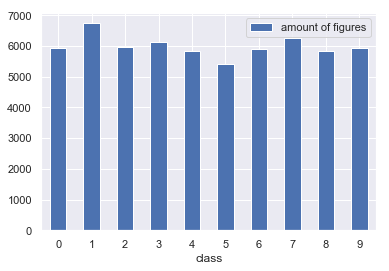

In [11]:
#依照class分群後，數各群的數量，並繪圖
dfCountPerClass=dfPath.groupby('class').count()
dfCountPerClass.rename(columns={'path':'amount of figures'},inplace=True)
dfCountPerClass.plot(kind='bar',rot=0)

[回索引](#索引)

####  1.c. 將圖片路徑資料切割成三份：取其80%做為train data。 之後，剩下的20%中取一半做validation data，另一半做test data

shape(all figures)=		 (60000, 2)
shape(fraction of figures)=	 (60000, 2)
shape(train)=			 (48000, 2)
shape(trainVal)=		 (6000, 2)
shape(test)=			 (6000, 2)


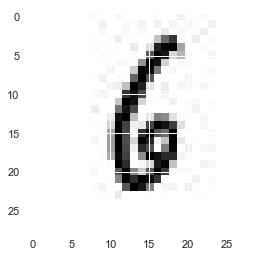

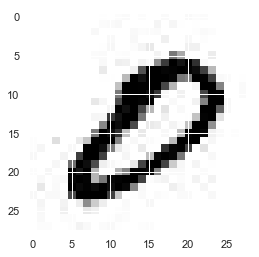

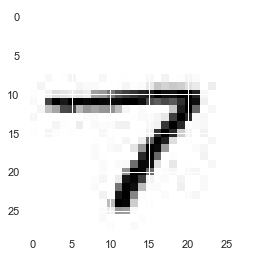

In [12]:
dfFrac=dfPath.sample(frac=1) # 打亂一下path data
    
train=dfFrac.sample(frac=0.8) # 將path data隨機取樣，80%的path data當train
test=dfFrac.drop(train.index) # 20%的path data當test

trainVal=test.sample(frac=0.5)
test=test.drop(trainVal.index)

print('shape(all figures)=\t\t',dfPath.shape)
print('shape(fraction of figures)=\t',dfFrac.shape)
print('shape(train)=\t\t\t',train.shape)
print('shape(trainVal)=\t\t',trainVal.shape)
print('shape(test)=\t\t\t',test.shape)

#隨便抓三張圖來看
for j in range(3):
    img=plt.imread(train['path'].iloc[j])
    plt.imshow(img,cmap="gray")
    plt.show()

[回索引](#索引)

####  1.d. 將圖片載入，存成數值矩陣

In [13]:
def dataLoad(dfPath):
    paths=dfPath['path'].values
    x=np.zeros((len(paths),28,28),dtype=np.float32 )
    for j in range(len(paths)):
        x[j,:,:]=plt.imread(paths[j])/255

    y=dfPath['class'].values
    return x,y

In [14]:
trainX,trainY=dataLoad(train)
trainValX,trainValY=dataLoad(trainVal)
testX,testY=dataLoad(test)

In [15]:
print('train:\t',trainX.shape,trainY.shape)
print('trainVal:',trainValX.shape,trainValY.shape)
print('test:\t',testX.shape,testY.shape)

train:	 (48000, 28, 28) (48000,)
trainVal: (6000, 28, 28) (6000,)
test:	 (6000, 28, 28) (6000,)


[回索引](#索引)

## 2. Softmax Regression

In [16]:
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.optimizers import SGD

#### 2.a. 將y 轉成one hot形式

In [17]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
trainYOneHot=enc.fit_transform(trainY.reshape(-1,1)) \
                .toarray()

trainValYOneHot=enc.fit_transform(trainValY.reshape(-1,1)) \
                   .toarray()

testYOneHot=enc.fit_transform(testY.reshape(-1,1)) \
               .toarray()

C:\Users\Student\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Student\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case yo

In [18]:
print('train:\t',trainX.shape,trainY.shape)
print('trainVal:',trainValX.shape,trainValY.shape)
print('test:\t',testX.shape,testY.shape)

train:	 (48000, 28, 28) (48000,)
trainVal: (6000, 28, 28) (6000,)
test:	 (6000, 28, 28) (6000,)


In [19]:
testYOneHot.shape

(6000, 10)

In [20]:
testYOneHot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

[回索引](#索引)

#### 2.b. 開始建立模型

In [21]:
from keras.layers import Flatten

In [22]:
trainX.shape

(48000, 28, 28)

In [23]:
model = Sequential()
model.add(Flatten(input_shape=(28,28)))

In [24]:
( model.predict(trainX) ).shape

(48000, 784)

In [25]:
model = Sequential()
model.add(Flatten(input_shape=(28,28)))    # 此層將28X28的資料攤成1維
model.add(Dense(10, activation='softmax') )# 此層將以十個神經元輸出十種數字的個別機率

sgd=SGD(lr=0.05) 
model.compile(optimizer= sgd,             # 告知模型訓練方式 
      loss='categorical_crossentropy',
      metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
# 檢視一下所訓練的模型
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


[回索引](#索引)

#### 2.c. 開始訓練模型

In [27]:
hist=model.fit(trainX, trainYOneHot,      
               epochs=20, batch_size=128,
               validation_data=(trainValX,trainValYOneHot))

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 6000 samples
Epoch 1/20
48000/48000 [==============================] - 1s 29us/step - loss: 2.2728 - acc: 0.6602 - val_loss: 1.9340 - val_acc: 0.7753
Epoch 2/20
48000/48000 [==============================] - 1s 12us/step - loss: 1.8238 - acc: 0.8045 - val_loss: 1.8415 - val_acc: 0.8080
Epoch 3/20
48000/48000 [==============================] - 1s 12us/step - loss: 1.7774 - acc: 0.8165 - val_loss: 1.8009 - val_acc: 0.8248
Epoch 4/20
48000/48000 [==============================] - 1s 11us/step - loss: 1.7545 - acc: 0.8234 - val_loss: 1.7845 - val_acc: 0.8250
Epoch 5/20
48000/48000 [==============================] - 1s 12us/step - loss: 1.7408 - acc: 0.8261 - val_loss: 1.7776 - val_acc: 0.8278
Epoch 6/20
48000/48000 [==============================] - 1s 12us/step - loss: 1.7306 - acc: 0.8301 - val_loss: 1.7670 - val_acc: 0.8305
Epoch 7/20
48000/48000 [==============================] - 1s 11us/step - loss: 1.

[回索引](#索引)

#### 2.d. 檢視訓練好的模型用於test data有多少準確率

In [28]:
score = model.evaluate(testX, testYOneHot, batch_size=128)
print()
print('\nloss=%s \naccuracy=%s'%(score[0],score[1]) )

6000/6000 [==============================] - 0s 6us/step


loss=1.6897010431289672 
accuracy=0.8351666669845581


In [29]:
# j=0
# trainValX[j:j+1,:][0].shape

[回索引](#索引)

#### 2.e. 檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok

In [30]:
for j in range(50):
    predY= model.predict(trainValX[j:j+1,:]).argmax()
    trueY= trainValYOneHot[j].argmax()
    print( predY,trueY,end='\t')

7 7	8 8	2 2	1 8	8 5	9 9	0 0	9 9	1 1	0 0	8 8	9 7	0 0	8 8	1 1	4 4	3 3	9 9	0 0	9 5	8 8	2 2	1 1	2 2	9 9	4 4	6 5	4 4	6 5	1 1	1 1	3 3	1 1	9 7	6 6	6 6	8 8	8 5	1 1	1 1	8 8	8 8	9 9	1 1	2 2	4 4	3 3	8 8	9 7	3 3	

[回索引](#索引)

#### 2.f. 畫出模型訓練過程

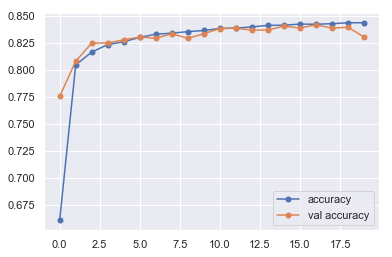

In [31]:
plt.plot(hist.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(hist.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回索引](#索引)

#### 2.g. 儲存模型和權重

In [32]:
import json
with open('first_try.json', 'w') as jsOut:
    json.dump(model.to_json(), jsOut)

model.save_weights('first_try.h5')

[回索引](#索引)

#### 2.h. 載入存好的模型和權重

In [33]:
from keras.models import model_from_json

In [34]:
with open('first_try.json', 'r') as jsIn:
    modelJson=json.load(jsIn)
    
modelLoaded=model_from_json(modelJson)
modelLoaded.load_weights('first_try.h5')

In [35]:
modelLoaded.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


[回索引](#索引)

#### 2.i. 輸出分類報告

In [36]:
predY=model.predict(testX).argmax(axis=1)
from sklearn.metrics import classification_report
print( classification_report(testY,predY) )

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       588
           1       0.92      0.98      0.95       673
           2       0.93      0.86      0.89       615
           3       0.70      0.93      0.80       596
           4       0.89      0.88      0.89       606
           5       0.00      0.00      0.00       532
           6       0.92      0.97      0.94       603
           7       0.95      0.83      0.89       600
           8       0.73      0.90      0.80       622
           9       0.68      0.94      0.79       565

   micro avg       0.84      0.84      0.84      6000
   macro avg       0.76      0.82      0.79      6000
weighted avg       0.77      0.84      0.80      6000



C:\Users\Student\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Student\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Student\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[回索引](#索引)

## 3. AlexNet-like Network

In [37]:
trainX=trainX.reshape(*trainX.shape,1)
trainValX=trainValX.reshape(*trainValX.shape,1)
testX=testX.reshape(*testX.shape,1)

#### 3.a. 建立模型

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D
from keras.layers import Activation
from keras.optimizers import SGD,Adam,Adamax

input_shape=(28,28,1)

model = Sequential()

#conv1
model.add(Conv2D(filters=32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
          
#conv2
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu')
         )
#pool1
model.add(MaxPooling2D(pool_size=(2, 2))
         )
#conv3
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu')
         )
#pool2
model.add(MaxPooling2D(pool_size=(2, 2))
         )
#dropout1
model.add(Dropout(0.5))
model.add(Flatten())
#dense1
model.add(Dense(128, activation='relu')
         )
#dropout2
model.add(Dropout(0.5))
#dense2
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.05),
              metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[回索引](#索引)

#### 3.b. 訓練模型

In [ ]:
%%time 
hist=model.fit(trainX, trainYOneHot, 
               epochs=30,
               batch_size=128,
               validation_data=(trainValX,trainValYOneHot),
              )

Train on 48000 samples, validate on 6000 samples
Epoch 1/30
48000/48000 [==============================] - 84s 2ms/step - loss: 1.0782 - acc: 0.6296 - val_loss: 0.1691 - val_acc: 0.9533
Epoch 2/30
48000/48000 [==============================] - 83s 2ms/step - loss: 0.2644 - acc: 0.9186 - val_loss: 0.1069 - val_acc: 0.9692
Epoch 3/30
48000/48000 [==============================] - 79s 2ms/step - loss: 0.1868 - acc: 0.9430 - val_loss: 0.0825 - val_acc: 0.9747
Epoch 4/30
48000/48000 [==============================] - 80s 2ms/step - loss: 0.1535 - acc: 0.9523 - val_loss: 0.0708 - val_acc: 0.9803
Epoch 5/30
48000/48000 [==============================] - 80s 2ms/step - loss: 0.1322 - acc: 0.9600 - val_loss: 0.0695 - val_acc: 0.9787
Epoch 6/30
48000/48000 [==============================] - 80s 2ms/step - loss: 0.1193 - acc: 0.9644 - val_loss: 0.0582 - val_acc: 0.9838
Epoch 7/30
48000/48000 [==============================] - 79s 2ms/step - loss: 0.1093 - acc: 0.9666 - val_loss: 0.0548 - val_acc:

[回索引](#索引)

#### 3.c. 檢視模型訓練結果

In [ ]:
plt.plot(hist.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(hist.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回索引](#索引)

#### 3.d. 檢視模型準確率

In [ ]:
score = model.evaluate(testX, testYOneHot, batch_size=128)
print()
print('\nloss=%s \naccuracy=%s'%(score[0],score[1]) )

[回索引](#索引)

#### 3.e. 檢視分類報告

In [ ]:
predY=model.predict(testX).argmax(axis=1)
from sklearn.metrics import classification_report
print( classification_report(predY,testY) )

[回索引](#索引)